# Tsiky Tafita RAKOTOHERISOA - Big Data Analytics

### Useful packages 

In [38]:
from pyspark.sql.functions import col, substring
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp, col
from pyspark.sql.functions import count
from pyspark.sql.functions import to_date
from pyspark.sql import functions as F
from pyspark.sql import *
from pyspark.sql.types import *
import seaborn as sns
import mob_data_utils as ut
import matplotlib.pyplot as plt
from pathlib import Path

### Path of the useful dataset

These file and folder are located in the same folder as my notebook

In [39]:
simulated_cdrs_data = "simulated_cdrs"
simulated_locs_data = "simulated_locs.csv"

## Task1: Data preprocessing and clean up

Perfom all the necessary data processing including adding location and date related columns to the dataset. You need to create a function that spits out preprocessed data after taking in raw data in the folder.

In [40]:
def preprocess_data(data, simulated_path):
    """
    Preprocesses  (CDRs) data and simulated location data.

    Parameters:
    data (str): Path to the CSV file containing the CDRs data.
    simulated_path (str): Path to the CSV file containing the simulated location data.

    Returns:
    pyspark.sql.DataFrame: A Spark DataFrame containing the preprocessed data.

    Steps:
    1. Create a SparkSession object.
    2. Read the CSV data (CDRs) with Spark.
    3. Repartition the DataFrame to speed up processing.
    4. Rename columns for consistency.
    5. Drop the 'cdrType' column as it is not needed.
    6. Convert 'cdrDatetime' to a timestamp data type.
    7. Drop the original 'cdrDatetime' column.
    8. Read the location data using Pandas and convert it to a Spark DataFrame.
    9. Merge the CDRs DataFrame with the location DataFrame on 'lastCallingCellid' and 'cell_id' columns.
    10. Drop rows with null values in the 'cell_id' column.
    11. Rename the 'cell_id' column to 'cellId'.
    12. Drop the 'callDuration' column as it is not needed.
    13. Return the final preprocessed DataFrame.
    """
    # Create a SparkSession object
    spark = SparkSession.builder.appName('preprocess_cdrs').getOrCreate()

    # Step 1: Read the CSV data with Spark
    df = spark.read.csv(data, header=True, inferSchema=True)

    # repartition to speed up
    df = df.repartition(100)

    # Step 2: Rename columns
    new_columns = ["cdrType", "cdrDatetime", "callDuration", "lastCallingCellid", "user_id"]
    df = df.toDF(*new_columns)

    # Step 3: Drop 'cdrType' column
    df1 = df.drop("cdrType")

    # Step 4: Convert 'cdrDatetime' to timestamp
    df2 = df1.withColumn("timestamp", to_timestamp(col("cdrDatetime").cast("string"), "yyyyMMddHHmmss"))

    # Step 5: Drop 'cdrDatetime' column
    df3 = df2.drop("cdrDatetime")

    # Step 6: Read location data using Pandas and convert to Spark DataFrame
    df_loc = pd.read_csv(simulated_path)
    sdf_loc = spark.createDataFrame(df_loc)

    # Step 7: Merge the DataFrames on 'lastCallingCellid' and 'cell_id'
    merge_df = df3.join(sdf_loc, df3["lastCallingCellid"] == sdf_loc["cell_id"], how='left')

    # Step 8: Drop rows with null values in 'cell_id'
    df4 = merge_df.na.drop(subset=["cell_id"])

    # Step 9: Rename 'cell_id' to 'cellId'
    df5 = df4.withColumnRenamed("cell_id", "cellId")

    # Step 10: Drop 'callDuration' column
    df6 = df5.drop("callDuration")

    # Return the final DataFrame
    return df6


In [41]:
# call the function to get the clean data

cleaned_df = preprocess_data(simulated_cdrs_data, simulated_locs_data)

### Dataset cleaned in spark dataframe

In [5]:
cleaned_df.show()

+-----------------+-------------------+-------------------+-------+------+------------------+---------+
|lastCallingCellid|            user_id|          timestamp|site_id|cellId|               lat|      lon|
+-----------------+-------------------+-------------------+-------+------+------------------+---------+
|          20893.0|6738184972994701163|2018-07-10 20:12:13|   S247| 20893|          -8.33183| 27.66598|
|          34249.0|6686008883907508553|2018-07-10 20:16:38|     S4| 34249|-8.569560000000001|  26.8459|
|          10338.0| 552905411444975143|2018-07-10 20:04:08|   S252| 10338|         -8.679244|26.938105|
|          20503.0|6561053214775088540|2018-07-10 20:06:27|    S62| 20503|         -8.023515| 27.38724|
|          10338.0|7458843081707054800|2018-07-10 20:17:23|   S252| 10338|         -8.679244|26.938105|
|          20503.0|8180403142783011287|2018-07-10 20:42:07|    S62| 20503|         -8.023515| 27.38724|
|          20893.0|3050647218048557132|2018-07-10 20:01:33|   S2

### Length of all dataset

In [44]:
cleaned_df.count()

36749404

### Cleaned data into csv file

In [7]:
# Writing the clean data into csv file and put it in dataset.csv

cleaned_df.coalesce(1).write.csv("dataset", header=True, mode="overwrite")

In [8]:
cleaned_file = Path('dataset')
csv_file_names = [file.name for file in cleaned_file.glob('*.csv')]

In [9]:
csv_file_names

['part-00000-d1191bee-a8a2-45dd-9c2a-e7b54d244ea8-c000.csv']

In [10]:
# Read the dataset

if csv_file_names:
    cleaned_df_csv = pd.read_csv(f"dataset/{csv_file_names[0]}")

### Final dataset preprocessed in csv

In [11]:
cleaned_df_csv.head()

,lastCallingCellid,user_id,timestamp,site_id,cellId,lat,lon
0,20893.0,6738184972994701163,2018-07-10T20:12:13.000+02:00,S247,20893,-8.331830,27.665980
1,34249.0,6686008883907508553,2018-07-10T20:16:38.000+02:00,S4,34249,-8.569560,26.845900
2,10338.0,552905411444975143,2018-07-10T20:04:08.000+02:00,S252,10338,-8.679244,26.938105
3,20503.0,6561053214775088540,2018-07-10T20:06:27.000+02:00,S62,20503,-8.023515,27.387240
4,10338.0,7458843081707054800,2018-07-10T20:17:23.000+02:00,S252,10338,-8.679244,26.938105


## Task2: Perform Data exploration  to generate the following statistics and tables.

#### Creating sample from the spark dataframe preprocessed

In [12]:
cleaned_sample_df = cleaned_df.sample(withReplacement=False, fraction=0.05)

In [14]:
print(f"Length of the sample: {cleaned_sample_df.count()}")

Length of the sample: 1838027


### 1. Total number of days in the dataset

In [15]:
df_with_date = cleaned_df.withColumn("date", to_date(col("timestamp")))
total_days = df_with_date.select("date").distinct().count()
print(f"Total number of days: {total_days}")

Total number of days: 15


### 2. Mean and median  number of calls per user

In [18]:
def summary_stats_for_user_events(spark_df, out_stats):
    """
    In this function, the goal is to take a big Spark
    DataFrame, group users and count each users events,
    convert to pandas DataFrame and generate summary stats
    :param: spark_df: preprocessed spark dataframe with data for multiple users
    :param: out_stats: CSV file path to save  the summary stats
    """
    # group user and count number of events
    # convert resulting spark dataframe to pandas
    pdf = spark_df.groupBy('user_id').count().toPandas()

    # change column "count" to num_events, remember that pdf is a pandas DataFrame
    pdf.rename(columns={"count": "num_events"}, inplace=True)

    # generate summary stats using pandas describe() function
    # use property T to transpose the describe results and convert them
    # into a DataFrame like this: pd.DataFrame(transposed describe results).reset_index()
    pdf_sum_stats = pd.DataFrame(pdf["num_events"].describe().T).reset_index()

    # remove the first row which has value "count"
    # you can use list indexing to achieve this
    pdf_sum_stats = pdf_sum_stats[1:]

    # Rename the column index into something informative. For instance, "Stat"
    pdf_sum_stats.rename(columns={"index": "Stat"}, inplace=True)

    # Rename the percentiles in numbers to something better
    # first, declare a dict with old and new names
    percentiles_rename = {
        "25%": "25th Percentile",
        "50%": "Median",
        "75%": "75th Percentile"
    }
    # next, update the Stats column using the pd.Series.map() function
    pdf_sum_stats["Stat"] = pdf_sum_stats["Stat"].map(percentiles_rename).fillna(pdf_sum_stats["Stat"])

    print("="*40)
    print("This is the summary statistics table of the sample dataset.")
    print("="*40)
    print()
    # please print the table below
    print(pdf_sum_stats)

    # Now save the summary stats to CSV
    pdf_sum_stats.to_csv(out_stats, index=False)


In [19]:
result_statistics = "result_statistics.csv"
summary_stats_for_user_events(cleaned_sample_df, result_statistics)

This is the summary statistics table of the sample dataset.

              Stat   num_events
1             mean     2.331750
2              std     3.078278
3              min     1.000000
4  25th Percentile     1.000000
5           Median     1.000000
6  75th Percentile     3.000000
7              max  1055.000000


I use the sample dataset for the summary statistics because of the issues: out of memories, I use 5% of the cleaned dataset.

## Task3: User Mobility patterns

### 1- Create and run function to create individual user mobility attributes (e.g., number of location visited per day). This function can return a function where each row is single user and columns include user_id,

#### Adding date column to the dataset in order to facilitate to extract date

In [20]:
# Adding date column to the dataset in order to facilitate to extract date

cleaned_df_csv['timestamp'] = pd.to_datetime(cleaned_df_csv['timestamp'])
cleaned_df_csv['date'] = cleaned_df_csv['timestamp'].dt.date  # Extracting only the date part

#### Function that generate basic user attributes 

In [28]:
def get_basic_user_mob_attribute(df):
    """
    This function generates basic user attributes to help explore the data and report on individual mobility metrics.
    :param df: Pandas DataFrame of single user data
    :return: Pandas DataFrame with columns ['date', 'unique_locs', 'max_distance']
    """

    # Column names
    datetimecol = 'timestamp'  # Column that contains timestamp information
    x = 'lon'  # Longitude column
    y = 'lat'  # Latitude column

    # Get a list of unique dates in ascending order
    dates = sorted(df['date'].unique())

    # Initialize an empty list to store processed results
    user_metrics = []
    unique_locs_count = []

    # Loop through each date to compute the required statistics
    for date in dates:
        # Filter the data for the current date
        dfd = df[df['date'] == date]

        # Get number of unique locations for this day using utility function
        uniq_xy = ut.va_generate_unique_locs(df=dfd, x=x, y=y)
        unique_locs_count = len(uniq_xy)

        # Calculate distances if there are more than one unique location
        if unique_locs_count > 1:
            # Generate the distance matrix for unique locations
            dist_mtx = ut.va_distance_matrix(uniq_xy)
            
            # Get the required columns that have 'to' in their name
            req_cols = [col for col in dist_mtx.columns if 'to' in col]
            
            # Find the maximum distance
            max_distance = np.max(dist_mtx[req_cols].values)
        else:
            max_distance = 0

        # Append the results to the list
        user_metrics.append({
            'date': date,
            'unique_locs': unique_locs_count,
            'max_distance': max_distance
        })

    # Convert the results list to a DataFrame
    user_metrics_df = pd.DataFrame(user_metrics)

    # Calculate aggregate values
    mean_max_distance = user_metrics_df['max_distance'].mean()
    mean_locs_per_day = user_metrics_df['unique_locs'].mean()
    num_of_days = len(dates)


    return {
        'date': num_of_days,
        'unique_locs': mean_locs_per_day,
        'max_distance': mean_max_distance
    }


In [29]:
def generate_basic_user_attributes_with_pandas(df, num_events_threshold=None):
    """
    Generate basic user mobility attributes to help further explore the data and 
    report on individual mobility metrics.

    :param df: Pandas DataFrame with multiple user data.
    :param outcsv: (optional) File path to save the output CSV.
    :param num_events_threshold: (optional) Minimum number of events required for a user.
    :return: Pandas DataFrame with user mobility attributes.
    """
    userid_col = 'user_id'
    
    # Get unique user IDs
    unique_user_ids_list = df[userid_col].unique()
    
    # Initialize an empty list to store user attributes
    user_data = []

    for user in unique_user_ids_list:
        df_user = df[df[userid_col] == user]

        # Apply threshold if specified
        if num_events_threshold and df_user.shape[0] < num_events_threshold:
            continue

        # Extract mobility attributes for the user
        results = get_basic_user_mob_attribute(df_user)

        # Append the processed user data to the list
        user_data.append({
            'user_id': user,
            'avg_Rg': results['max_distance'],
            'avg_locs_per_day': results['unique_locs'],
            'total_days': results['date']
        })

    # Convert the list of user data to a Pandas DataFrame
    result_df = pd.DataFrame(user_data)

    # Print the first 10 rows of the DataFrame
    print("=" * 40)
    print("This is the top 10 rows of the DataFrame.")
    print("=" * 40)
    print(result_df.head(10))

    return result_df


### Creating sample from dataset cleaned 

In [23]:
cleaned_df_csv_sample = cleaned_df_csv.sample(n=50000)

In [24]:
cleaned_df_csv_sample.head()

,lastCallingCellid,user_id,timestamp,site_id,cellId,lat,lon,date
22488905,12177.0,2522812212399458627,2018-07-04 07:51:17+02:00,S37,12177,-8.560890,26.835400,2018-07-04
26017011,22193.0,8673656195306724057,2018-07-02 19:56:03+02:00,S208,22193,-9.059104,28.273943,2018-07-02
11157014,22192.0,2355738967524394466,2018-07-12 21:01:29+02:00,S208,22192,-9.059104,28.273943,2018-07-12
30113717,20542.0,1584470840993424070,2018-07-02 07:43:01+02:00,S211,20542,-8.124386,27.961957,2018-07-02
21628186,14332.0,7339108761226147574,2018-07-02 18:54:14+02:00,S221,14332,-8.537976,26.730825,2018-07-02


In [30]:
dataframe = pd.DataFrame(generate_basic_user_attributes_with_pandas(cleaned_df_csv_sample))

This is the top 10 rows of the DataFrame.
               user_id  avg_Rg  avg_locs_per_day  total_days
0  2522812212399458627     0.0               1.0           1
1  8673656195306724057     0.0               1.0           1
2  2355738967524394466     0.0               1.0           1
3  1584470840993424070     0.0               1.0           1
4  7339108761226147574     0.0               1.0           1
5  3228276075531602480     0.0               1.0           1
6  8827334164821636524     0.0               1.0           1
7  6782920914927242685     0.0               1.0           1
8  1699884572966267714     0.0               1.0           2
9  1627646416900432556     0.0               1.0           1


### 2- Save the user attributes as a CSV file

In [31]:
dataframe.to_csv('user_attribute.csv', index=False, header=True)

In [32]:
user_att = pd.read_csv("user_attribute.csv")
user_att

,user_id,avg_Rg,avg_locs_per_day,total_days
0,2522812212399458627,0.0,1.0,1
1,8673656195306724057,0.0,1.0,1
2,2355738967524394466,0.0,1.0,1
3,1584470840993424070,0.0,1.0,1
4,7339108761226147574,0.0,1.0,1
...,...,...,...,...
47477,1653083404939399082,0.0,1.0,1
47478,6268601110514198932,0.0,1.0,1
47479,5154788556232348631,0.0,1.0,1
47480,5752307768364585472,0.0,1.0,1


### 3- Explore correlation between avg_Rg (mean radius of gyration)  and avg_locs_per_day. Please report the correlation results appropriately with a plot showing the correlation coefficient

In [33]:
dataframe[["avg_Rg", "avg_locs_per_day"]].corr()

,avg_Rg,avg_locs_per_day
avg_Rg,1.000000,0.434379
avg_locs_per_day,0.434379,1.000000


In [35]:
print(f'The correlation between avg_locs_per_day and avg_Rg is :{dataframe[["avg_Rg", "avg_locs_per_day"]].corr()['avg_locs_per_day'].iloc[0]}')

The correlation between avg_locs_per_day and avg_Rg is :0.43437865246454405


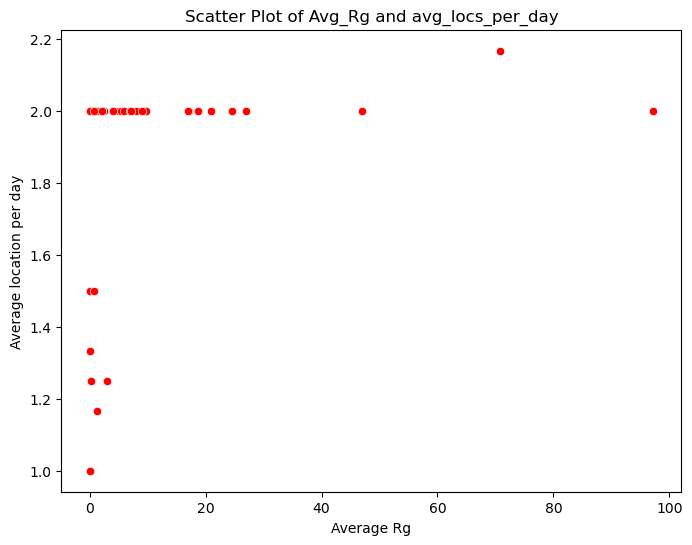

In [36]:
# Scatter plot using Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(x='avg_Rg', y='avg_locs_per_day', data=dataframe, color='red')

# Label the axes and title
plt.xlabel('Average Rg')
plt.ylabel('Average location per day')
plt.title('Scatter Plot of Avg_Rg and avg_locs_per_day')

plt.show()


<Axes: >

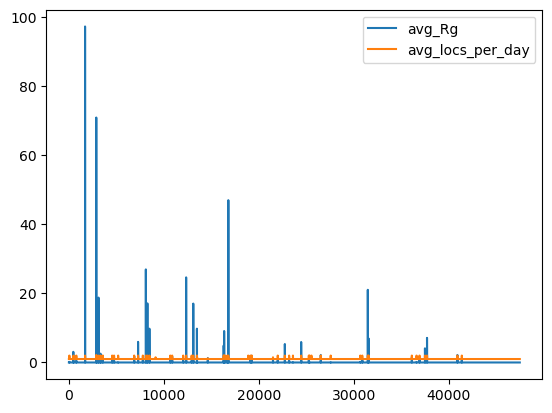

In [37]:
dataframe[["avg_Rg", "avg_locs_per_day"]].plot()

## Task4:  What large dataset challenges did you face and how did you solve them. Please explain the decisions you made and why you made them. For example, if you sampled the data, how much of the data did you sample? [ 300 words]

When working with large datasets, several challenges arise, such as memory limitations, processing speed, and ensuring data consistency. Below are the challenges I faced during the preprocessing of the data and the decisions I made to address them:

**1. Memory Limitations:**

  ***Challenge:*** The dataset was too large to fit into memory, especially when working with Spark in distributed environments. Trying to process the entire dataset on a single machine could result in memory overflows or crashes.


  ***Solution:*** I used repartition(100) to increase the number of partitions for parallel processing. This distributed the data processing workload across multiple nodes, ensuring that no single partition would exceed memory limits and improving the overall processing speed. And the third and second task, I choose to use sample because of that memory limitations.
 


  I used this because repartitioning allowed Spark to handle large datasets more efficiently, especially when working with operations like join that are computationally expensive. This approach ensures the workload is distributed, and no node is overwhelmed, optimizing memory usage and processing time.


**2. Data Quality:**

  ***Challenge:*** There were missing or null values in the data, especially in critical columns such as cell_id. These missing values could lead to errors or inconsistencies in the final dataset.


  ***Solution:*** I used .na.drop(subset=["cell_id"]) to remove rows with null cell_id values after the join. This step was critical to ensure that the final dataset had complete and valid data for further analysis.


  I choose to use this because handling missing data is crucial for maintaining data integrity. By removing rows with essential missing values, I ensured that only valid records were processed, which helped maintain the accuracy of subsequent analysis.


**3. Handling Date-Time Conversion:**

    
***Challenge:*** The cdrDatetime column was in a non-standard format, which made it challenging to work with as a timestamp for time-based operations.


***Solution:*** I used to_timestamp() with a specified format ("yyyyMMddHHmmss") to convert cdrDatetime into a proper timestamp.
    
    
I use this kind of preprocessing because this conversion enabled time-based filtering, grouping and analysis.






**4. Data Integration:**


***Challenge:*** Merging data from multiple sources (call data and location data).


***Solution:*** I used join() to combine the two datasets on common keys (lastCallingCellid and cell_id), followed by dropping rows with null values in the cell_id column.

**5. Performance Optimization:**


***Challenge:*** Large-scale join operations can significantly slow down data processing, especially when dealing with millions of rows.


***Solution:*** I optimized the performance by ensuring the join keys were indexed and ensuring the process was distributed across multiple partitions.


- *Overall, these decisions allowed me to preprocess a large dataset efficiently while maintaining data quality and ensuring that the analysis could be performed accurately. By handling memory, data quality, and performance issues early in the process, I was able to optimize the analysis pipeline and prevent potential errors.*